# Problem Set 5 - Reinforcement Learning and Transformers 

<h4> Reinforcement Learning Section by Sid Mysore. <br> Transformers Section adapted from previous homework designed by Ruizhao Zhu with help of Brian Kulis and Ashok Cutkosky<br> </h4>

---

This assignment is broken up into 2 parts:
1. Implementing and testing basic deep RL algorithms for:
    * Discrete action spaces with DQN (simplified from the seminal Nature paper)
    * Continuous action spaces with DDPG (a popular basic actor-critic algorithm)
2. Understanding the basic structure of Transformers

This code has been tested locally on Linux, Windows 10 and MacOS, and on Colab

---

Name: `Zhenghang Yin`

BUID: `U82871437`

## Notes before running code

1. If running on Windows, note that some packages may throw warnings or errors - if you encounter this, try the fixes recommended by the error message(s)

2. Additional packages may be required for running locally. This notebook is configured to help you install specific versions of the required packages but if you are concerned about them overwriting exisiting configs for other projects, it is recommended to create a new python environment.

2. When running code, make sure the following files are in your current working directory as they will be needed for some of the RL logging and plotting:
    * `test_policy.py`
    * `logx.py`
    * `plot.py`

In [ ]:
# Prerequisites

# load all the files
!ln -s /content/drive/MyDrive/Common\ Data/CS523/hw5/logx.py logx.py
!ln -s /content/drive/MyDrive/Common\ Data/CS523/hw5/plot.py plot.py
!ln -s /content/drive/MyDrive/Common\ Data/CS523/hw5/test_policy.py test_policy.py


def DPATH(*args: str) -> str:
    from os.path import join
    return join("/content/drive/MyDrive/Users/青椒/CS523/hw5_stuffs", *args)


def check_gpu() -> None:
    result = !nvidia-smi --query-gpu=name --format=csv,noheader
    answer = result[0].strip()
    if len(answer) == 0 or "nvidia-smi" in (answer.lower()):
        print("No gpus are found in this Notebook.")
    else:
        print(f"You are using: {answer}")

check_gpu()

No gpus are found in this Notebook.


## Q1 Deep Q Learning (30 Points)

#### Key Concepts

<img src="http://ai.bu.edu/DL523/HW5_files/rl_diagram.png" width="360em">

The main components of the RL optimization loop are the agent and the environment. The environment is the world that the agent interacts with. At every step of interaction, the agent sees a (possibly partial) observation of the state of the world, and then decides on an action to take. The environment may change as a response to the agents' actions on it, but may also change on its own.

The agent also perceives a reward signal from the environment, a number that tells it how good or bad the current world state is. The goal of the agent is to maximize its cumulative reward. Reinforcement learning methods are ways that the agent can learn behaviors to achieve its goal.

##### Fully vs. Partially Observable State-spaces

When the agent is able to observe the complete state of the environment, we say that the environment is fully observed. When the agent can only see a partial observation, we say that the environment is partially observed. For the purposes of this homework, we will be dealing with fully observable environments.

##### Discrete vs. Continuous Action-spaces

Different environments allow different kinds of actions. The set of all valid actions in a given environment is often called the action space. Some environments, like old Atari games and Go, have discrete action spaces, where only a finite number of moves are available to the agent. Other environments, like where the agent controls a robot in a physical world, have continuous action spaces. In continuous spaces, actions are real-valued vectors. In this homework, we will consider problems involving both types of action spaces and some simple algorithms for solving them.

##### The RL Problem

The reward function R is critically important in reinforcement learning. It depends on the current state of the world, the action just taken, and the next state of the world:

$$
r_t = R(s_t, a_t, s_{t+1})
$$

although frequently this is simplified to just a dependence on the current state, $r_t = R(s_t)$, or state-action pair $r_t = R(s_t,a_t)$.

The goal of the agent is to maximize the expected cumulative reward over a trajectory, $\tau$, but this actually can mean a few things. We’ll notate all of these cases with $R(\tau)$. The expected return, denoted by $J(\pi)$, is then:

$$
J(\pi) = \mathbb{E}_{\tau\sim \pi}{R(\tau)}
$$

The central optimization problem in RL can then be expressed by

$$
\pi^* = \arg \max_{\pi} J(\pi)
$$

with $\pi^*$ being the optimal policy.

##### The need to approximate value functions

A way to frame the RL problem would be to say that we want actions taken by our agents to maximize the expected achievable value, given a starting state. This can be in the form of a state-value function:

$$
V^{\pi}(s) = \mathbb{E}_{\tau \sim \pi}[R(\tau) | s_0 = s]\text{ for states }s \in S
$$

or a state-action value function (often called a Q-function):

$$
Q^{\pi}(s,a) = \mathbb{E}_{\tau \sim \pi}[R(\tau) | s_0 = s, a_0 = a]\text{ for states }s \in S\text{ and actions }a \in A
$$

Both value representations obey self-consistency equations called Bellman equations, of which the basic idea is that:

    The value of your starting point is the reward you expect to get from being there, plus the value of wherever you land next.

For a given policy, $\pi$, the Bellman equations are:

$$
V^{\pi}(s_t) = \mathbb{E}_{a \sim \pi}[r(s_t,a_t) + \gamma V^\pi(s_{t+1})]
$$

$$
Q^{\pi}(s_t, a_t) = \mathbb{E}_{s}[r(s_t,a_t) + \gamma Q^\pi(s_{t+1},\pi(s_{t+1}))]]
$$

The optimal policy is one that maximizes the expected values $V$ and/or $Q$. This homework will mainly focus on Q-learning techniques, so we are mainly concerned with techniques that consider the latter.

#### Some Setup

Now for some setup to use during the RL parts of this homework.

We will be representing policy and value functions by neural networks. The problems we're working on are fairly simple so we'll be using some simple multi-layer perceptrons (MLPs).

Run the below if you're starting from a clean environment or suspect you may have the wrong versions of packages 

*(Also assumes the packages `ipython` and `jupyter` are already installed since you need them anyway to use this notebook)*

In [ ]:
!pip install "gym[classic_control]==0.17.3"
!pip install "torch==1.10.0"
!pip install numpy scipy matplotlib pandas sympy nose seaborn joblib

     |████████████████████████████████| 154 kB 5.2 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import gym
import time
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import typing

from logx import EpochLogger
from test_policy import load_policy_and_env, run_policy
from plot import plot_data, get_datasets

def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

We also use replay buffers to store trajectories during rollouts so that we can sample from them to aid in training. By storing experiences in replay buffers and sampling from them, we can mitigate catastrophic forgetting (when RL agents forget old experiences).

The Replay Buffer mainly keeps a store of the core elements of the Markov Decision Process (MDP) tuple for each interaction of the agent in the training environment. This includes the observed state (obs), the action taken (act), the reward received (rew), the resultant next state after the action (next_obs) and whether the episode was completed/terminated (done).

This data can then be sampled during optimization to use for batch updates, as we will do in this homework.

In [ ]:
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer
    """
    def __init__(self,
                 obs_dim: int,
                 act_dim: int,
                 size: int,
                 discrete: bool=False):
        self.discrete=discrete
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self,
              obs: torch.Tensor,
              act: int,
              rew: float,
              next_obs: torch.Tensor,
              done: bool):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.int64 if (k=='act' and self.discrete) else torch.float32) for k,v in batch.items()}

### Q1.1 Deep Q Networks (DQNs)

The main idea behind Q-learning is that if we had a function $Q^*:State×Action \rightarrow \mathbb{R}$, that could tell us what our return would be, if we were to take an action in a given state, then we could easily construct a policy that maximizes our rewards:

$$
\pi^*(s_t) = \operatorname{argmax}_a Q^*(s_t,a)
$$

However, we don’t know everything about the world, so we don’t have access to $Q^*$. But, since neural networks are universal function approximators, we can simply create one and train it to resemble $Q^*$.

For a discrete action space, a Q-network can be used to estimate the Q-values for each possible action, given a state. The policy can then be designed such that:

$$
a^\pi = \operatorname{argmax}_a Q^\pi(s_t,a)
$$

For our training update rule, we’ll use a fact that every $Q$ function for some policy obeys the Bellman equation:

$$
Q^\pi(s_t,a) = r + \gamma Q^\pi(s_{t+1},\pi(s_{t+1}))
$$

The difference between the two sides of the equality is known as the temporal difference error

$$
\delta = Q(s_{t},a) - (r + \gamma \max_a Q(s_{t+1}, a))
$$



In [ ]:
class DQN(nn.Module):
    def __init__(self, obs_space, act_space, hidden_sizes=(64,64), activation=nn.ReLU, output_activation=nn.Identity):
        super().__init__()
        self.obs_space = obs_space
        self.act_space = act_space
        self.hidden_sizes = hidden_sizes

        self.Q = mlp([obs_space.shape[0]] + list(hidden_sizes) + [act_space.n],
                     activation,
                     output_activation)

    def forward(self, obs):
        # Return output from network scaled to action space limits.
        return self.Q(obs)

    def act(self, obs):
        with torch.no_grad():
            return self.Q(obs[None,]).max(1)[1].numpy()[0]

We will use the above simple DQN structure to train a policy to solve OpenAI gym's CartPole problem.

In [ ]:
# Training hyperparameters
steps_per_epoch=4000
epochs=20
gamma=0.99
polyak=0.99  
q_lr=1e-3
batch_size=100
start_steps=10000
update_after=1000 
update_every=50
act_noise=0.1
num_test_episodes=10
max_ep_len=1000
save_freq=1

We will also define a location for the trained models and logs to get saved. By default, it'll be stored in the current working directory but you may change this 

In [ ]:
# Define the directory location to save dqn logs and models
dqn_output_dir = DPATH('dqn')

# Logger setup
logger_kwargs={'output_dir':dqn_output_dir, 'exp_name':'dqn_CartPole'}
logger = EpochLogger(**logger_kwargs)

Logging data to /content/drive/MyDrive/Users/青椒/CS523/hw5_stuffs/dqn/progress.txt


The problem we'll be working on for DQN is the [CartPole](https://gym.openai.com/envs/CartPole-v1/) OpenAI Gym task. 

The agent observes the positions and velocities of the cart and pole and can take one of two discrete options to either move the cart to the left, or the right, to try and keep the pole balanced.

The episode keeps going for up to 200 steps so long as the pole doesn't fall over too much, and the agent fails if the pole falls more than $\pm 12$ degrees from the vertical. 

For every step that it remains 'alive', the agent gets 1 point of reward. The objective is to maximize this reward, which is equivalent to keep the pole balanced for as long as possible.

Additional details for the implementation of this environment can be found via the code [source](https://github.com/openai/gym/blob/4ede9280f9c477f1ca09929d10cdc1e1ba1129f1/gym/envs/classic_control/cartpole.py).

A random agent would quickly fail to balance the pole, as below (the frame hitches are due to the agent failing and the episode being reset)

<img src="http://ai.bu.edu/DL523/HW5_files/cartpole_random_demo.gif" width="360em">

But a trained agent can successfully solve this problem (using solution code for this HW).

<img src="http://ai.bu.edu/DL523/HW5_files/cartpole_demo.gif" width="360em">

In [ ]:
# Environment Definition
env_fn = lambda :gym.make('CartPole-v0')
env, test_env = env_fn(), env_fn()
obs_dim = env.observation_space.shape
act_dim = env.action_space.shape

# Seeding
seed=0
torch.manual_seed(seed)
np.random.seed(seed)
env.seed(seed)
test_env.seed(seed)

# Experience buffer
replay_size=int(1e6) 
replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size, discrete=True)

# Create DQN module
Qnet = DQN(env.observation_space, env.action_space)

To stabilize training we also use a 'target' Q-network which is held relatively constant and is periodically updated with weights from the DQN being trained.

In [ ]:
# Create target network
Qtarg = deepcopy(Qnet)

# Freeze target networks with respect to optimizers (only update via polyak averaging)
for p in Qtarg.parameters():
    p.requires_grad = False

# Set up model saving
logger.setup_pytorch_saver(Qnet)

We can next initialize some helper functions

In [ ]:
# Helper Functions
def get_action(o, eps_thresh):
    a = Qnet.act(torch.as_tensor(o, dtype=torch.float32))
    if np.random.rand() < eps_thresh:
        a = env.action_space.sample()
    return a

def test_agent():
    for j in range(num_test_episodes):
        o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
        while not(d or (ep_len == max_ep_len)):
            # Take deterministic actions at test time (noise_scale=0)
            o, r, d, _ = test_env.step(get_action(o, 0))
            ep_ret += r
            ep_len += 1
        logger.store(TestEpRet=ep_ret, TestEpLen=ep_len)

### Define DQN Q-learning Loss [10 points]

For a sampled batch of data from the replay buffer consisting of sets of observations `o`, corresponding actions taken `a`, achieved reward `r`, resultant observations `o2`, and a flag indicating if the recorded step solved the problem or ended the episode `d`, we compute the DQN loss in 4 main steps:

- [x] Compute the Q-network output for `o` and extract Q-values for specific actions taken, $a_t$: $Q(s_t,a_t)$
    - Actions, $a_t \in [0,n-1]$, are indices into a discrete action space with $n$ possible actions.
- [x] Next, compute the Bellman backup: $b = r + \gamma \max_{a'} Q_{targ}(s_{t+1},a')$
    - remember that $\gamma = 0$ if $d=1$ and that you don't need to track gradients through the target Q-network.
- [x] Compute the Bellman error:

$$
e = Q(s,a) - b
$$

- [x] Finally compute the Q-loss:

$$
l_Q = \frac{1}{N} || e ||_2
$$





In [ ]:
import pdb

# Set up function for computing DQN Q-loss
def compute_loss_q(data: typing.Dict[str, torch.Tensor]):
    # Batch data sample:

    # O is the observation, a sets of Observation, each line a status
    # A is the action
    # R is the reward
    # o2 is the resultant observations
    # d is the done flag, which is False if the episode is not over, and True if it is over
    o, a, r, o2, d = data['obs'], data['act'], data['rew'], data['obs2'], data['done']

    """ STUDENT CODE GOES HERE """
    # Compute q values for observations as appropriate
    q = torch.sum(Qnet(o) * F.one_hot(a), dim=1).view(-1, 1)

    with torch.no_grad():
        qtarg_o = Qtarg(o2)
        # there's values and indices in torch.max's result.
        # here we only need values.
        q_target = torch.max(qtarg_o, dim=1).values
        backup = r + (1 - d) * gamma * q_target
    
    loss_q = F.mse_loss(torch.squeeze(q), backup).mean()
    """ STUDENT CODE ENDS """

    # Useful info for logging
    loss_info = dict(QVals=q.detach().numpy())

    return loss_q, loss_info

# Set up optimizers for policy and q-function
q_optimizer = Adam(Qnet.Q.parameters(), lr=q_lr)

def update(data):
    # First run one gradient descent step for Q.
    q_optimizer.zero_grad()
    loss_q, loss_info = compute_loss_q(data)
    loss_q.backward()
    q_optimizer.step()

    # Record things
    logger.store(LossQ=loss_q.item(), **loss_info)

    # Finally, update target networks by polyak averaging.
    with torch.no_grad():
        for p, p_targ in zip(Qnet.parameters(), Qtarg.parameters()):
            # NB: We use an in-place operations "mul_", "add_" to update target
            # params, as opposed to "mul" and "add", which would make new tensors.
            p_targ.data.mul_(polyak)
            p_targ.data.add_((1 - polyak) * p.data)

Now we run training.

While running the code, pay attention the following logged information to determine if things are progressing well:

1. For the first few thousand steps, the agents act randomly so you'll likely see low rewards that don't improve until more than `start_steps` steps have elapsed.
2. Average Episode and Test Episode returns should generally be increasing (up to 200 which is the max for the CartPole problem)
3. Despite optimizing the Q-value loss, the fact that we're having the network learn an arbitrary value means that we may never hit a loss of 0 - the loss should stabilize after some time though (feel free to experiment with more epochs of training)

In [ ]:
# Prepare for interaction with environment
total_steps = steps_per_epoch * epochs
o, ep_ret, ep_len = env.reset(), 0, 0

# Main loop: collect experience in env and update/log each epoch
for t in range(total_steps):
    
    # Until start_steps have elapsed, randomly sample actions
    # from a uniform distribution for better exploration. Afterwards, 
    # use the learned policy (with some noise, via act_noise). 
    if t > start_steps: 
        a = get_action(o, act_noise)
    else:
        a = env.action_space.sample()

    # Step the env
    o2, r, d, _ = env.step(a)
    ep_ret += r
    ep_len += 1

    # Ignore the "done" signal if it comes from hitting the time
    # horizon (that is, when it's an artificial terminal signal
    # that isn't based on the agent's state)
    d = False if ep_len==max_ep_len else d

    # Store experience to replay buffer
    replay_buffer.store(o, a, r, o2, d)

    # Super critical, easy to overlook step: make sure to update 
    # most recent observation!
    o = o2

    # End of trajectory handling
    if d or (ep_len == max_ep_len):
        logger.store(EpRet=ep_ret, EpLen=ep_len)
        o, ep_ret, ep_len = env.reset(), 0, 0

    # Update handling
    if t >= update_after and t % update_every == 0:
        for _ in range(update_every):
            batch = replay_buffer.sample_batch(batch_size)
            update(data=batch)

    # End of epoch handling
    if (t+1) % steps_per_epoch == 0:
        epoch = (t+1) // steps_per_epoch

        # Save model
        if (epoch % save_freq == 0) or (epoch == epochs):
            logger.save_state({'env': env}, None)

        # Test the performance of the deterministic version of the agent.
        test_agent()

        # Log info about epoch
        logger.log_tabular('Epoch', epoch)
        logger.log_tabular('EpRet', with_min_and_max=True)
        logger.log_tabular('TestEpRet', with_min_and_max=True)
        logger.log_tabular('EpLen', average_only=True)
        logger.log_tabular('TestEpLen', average_only=True)
        logger.log_tabular('TotalEnvInteracts', t)
        logger.log_tabular('QVals', with_min_and_max=True)
        logger.log_tabular('LossQ', average_only=True)
        logger.dump_tabular()

env.close()
test_env.close()

---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |            22.1 |
|          StdEpRet |            11.5 |
|          MaxEpRet |              66 |
|          MinEpRet |               8 |
|  AverageTestEpRet |             176 |
|      StdTestEpRet |            20.6 |
|      MaxTestEpRet |             200 |
|      MinTestEpRet |             141 |
|             EpLen |            22.1 |
|         TestEpLen |             176 |
| TotalEnvInteracts |           4e+03 |
|      AverageQVals |            12.5 |
|          StdQVals |            8.59 |
|          MaxQVals |            33.1 |
|          MinQVals |            -3.7 |
|             LossQ |           0.487 |
---------------------------------------
---------------------------------------
|             Epoch |               2 |
|      AverageEpRet |            22.8 |
|          StdEpRet |            11.3 |
|          MaxEpRet |              67 |
|          MinEpRet |               9 |


No file named config.json


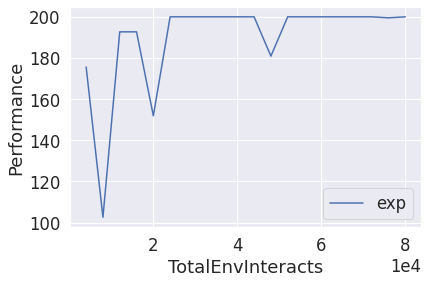

In [ ]:
plt.figure()
data = get_datasets(dqn_output_dir)
plot_data(data, xaxis='TotalEnvInteracts', value='Performance', smooth=1)

We can also run the trained agents as below (set render=True to visualize - note that additional settings may be required to view on Colab or on a remote server)

Note: In order for this code to work, the DQN model definition should be in scope.

The solved CartPole controller would typically have EpRet close to 200 (where 200 is the max) - If it doesn't quite plateau there, try rerunning the training (we're only training it for a short while with only sligtly tuned hyperparameters so it's possible that it may not stably plateau)

In [ ]:
playback_env, get_action = load_policy_and_env(dqn_output_dir, 'last', True)
run_policy(playback_env, get_action, num_episodes=10, render=False)
playback_env.close()



Loading from /content/drive/MyDrive/Users/青椒/CS523/hw5_stuffs/dqn/pyt_save/model.pt.


Logging data to /tmp/experiments/1650459421/progress.txt
Episode 0 	 EpRet 200.000 	 EpLen 200
Episode 1 	 EpRet 200.000 	 EpLen 200
Episode 2 	 EpRet 200.000 	 EpLen 200
Episode 3 	 EpRet 200.000 	 EpLen 200
Episode 4 	 EpRet 200.000 	 EpLen 200
Episode 5 	 EpRet 200.000 	 EpLen 200
Episode 6 	 EpRet 200.000 	 EpLen 200
Episode 7 	 EpRet 200.000 	 EpLen 200
Episode 8 	 EpRet 200.000 	 EpLen 200
Episode 9 	 EpRet 200.000 	 EpLen 200
-------------------------------------
|    AverageEpRet |             200 |
|        StdEpRet |               0 |
|        MaxEpRet |             200 |
|        MinEpRet |             200 |
|           EpLen |             200 |
-------------------------------------


### Q1.2 Deep Deterministic Policy Gradient (DDPG) - An Actor-Critic Algorithm

Next, we'll implement a Q-learning algorithm for continuous control using a popular actor-critic algortihm, DDPG.

One of the main traits of actor-critic algortihsm is that unlike with DQNs:
1. The policy network and value estimation network are separated into two separate, distinct functions
2. They can be used to solve continuous controls problems, unlike DQNs which are limited to discrete action spaces.

The Q-learning side of training the critic works similarly to DQNs, except that Q-networks now take states and actions both as inputs to estimate a Q-value, as opposed to simultaneously estimating Q values over all possible discrete actions.

The Policy learning in DDPG is fairly simple. We want to learn a deterministic policy $\pi_{\theta}(s)$ (parameterized by $\theta$) which gives the action that maximizes $Q_{\phi}(s,a)$, a Q-value critic parameterized by $\phi$. Because the action space is continuous, and we assume the Q-function is differentiable with respect to action, we can just perform gradient ascent (with respect to policy parameters only) to solve

$\max_{\theta} \mathbb{E}_{s \sim {\mathcal D}} [ Q_{\phi}(s, \pi_{\theta}(s)) ]$

Note that the Q-function parameters are treated as constants here.

In [ ]:
class MLPActor(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit):
        super().__init__()
        pi_sizes = [obs_dim] + list(hidden_sizes) + [act_dim]
        self.pi = mlp(pi_sizes, activation, nn.Tanh)
        self.act_limit = act_limit

    def forward(self, obs):
        # Return output from network scaled to action space limits.
        return self.act_limit * self.pi(obs)

class MLPQFunction(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs, act):
        q = self.q(torch.cat([obs, act], dim=-1))
        return torch.squeeze(q, -1) # Critical to ensure q has right shape.

class MLPActorCritic(nn.Module):

    def __init__(self, observation_space, action_space, hidden_sizes=(256,256),
                 activation=nn.ReLU):
        super().__init__()

        obs_dim = observation_space.shape[0]
        act_dim = action_space.shape[0]
        act_limit = action_space.high[0]

        # build policy and value functions
        self.pi = MLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit)
        self.q = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)

    def act(self, obs):
        with torch.no_grad():
            return self.pi(obs).numpy()

For this part of the homework, we'll test DDPG on a simple inverted pendulum problem.

As before, in addition to the main trained networks, we build additional target networks to stabilize training.

We will also set the logging directory to be a part of the current working directory but feel free to change that as necessary

In [ ]:
# Define the directory location to save DDPG logs and models
ddpg_output_dir = DPATH('ddpg')

# Logger setup
logger_kwargs={'output_dir': ddpg_output_dir, 'exp_name':'ddpg_pendulum'}
logger = EpochLogger(**logger_kwargs)

Logging data to /content/drive/MyDrive/Users/青椒/CS523/hw5_stuffs/ddpg/progress.txt


The problem we'll be working on for DDPG is the (inverted) [Pendulum](https://gym.openai.com/envs/CartPole-v1/) OpenAI Gym task. 

The agent observes the angular position and velocity of the pendulum and can apply a continuous-valued torque to try and balance the pendulum.

The episode keeps going for up to 200 steps and every step the agent gets reward mainly proportional to how far off it is from balancing the inverted pendulum, with smaller reward components related to how fast the pendulum is moving and how much torque is being applied. The objective is to maximize this reward, which is equivalent to balancing the inverted pendulum quickly and for as long as possible.

Additional details for the implementation of this environment can be found via the code [source](https://github.com/openai/gym/blob/4ede9280f9c477f1ca09929d10cdc1e1ba1129f1/gym/envs/classic_control/pendulum.py).

A random agent (or a poorly trained one) is unlikely to successfully balance the pendulum, as seen below:

<img src="http://ai.bu.edu/DL523/HW5_files/pendulum_random_demo.gif" width="360em">

But a well trained agent can successfully solve this problem (using solution code for this HW).

<img src="http://ai.bu.edu/DL523/HW5_files/pendulum_demo.gif" width="360em">

In [ ]:
# Training hyperparameters
steps_per_epoch=4000
epochs=20
gamma=0.99
polyak=0.995
batch_size=100
start_steps=10000
update_after=1000 
update_every=50
act_noise=0.1
num_test_episodes=10
max_ep_len=1000
save_freq=1

pi_lr=1e-3 
q_lr=1e-3

# Environment Definition
env_fn = lambda :gym.make('Pendulum-v0')
env, test_env = env_fn(), env_fn()
obs_dim = env.observation_space.shape
act_dim = env.action_space.shape[0]
# Action limit for clamping: critically, assumes all dimensions share the same bound!
act_limit = env.action_space.high[0]

# Seeding
seed=0
torch.manual_seed(seed)
np.random.seed(seed)
env.seed(seed)
test_env.seed(seed)

# Experience buffer
replay_size=int(1e6) 
replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size)

# Create actor-critic module and target networks
ac = MLPActorCritic(env.observation_space, env.action_space)
ac_targ = deepcopy(ac)

# Freeze target networks with respect to optimizers (only update via polyak averaging)
for p in ac_targ.parameters():
    p.requires_grad = False

# Set up model saving
logger.setup_pytorch_saver(ac)

We can next initialize modified helper functions - similar to the ones before but setup for the different architecture

In [ ]:
# Helper Functions
def get_action(o, noise_scale):
    a = ac.act(torch.as_tensor(o, dtype=torch.float32))
    a += noise_scale * np.random.randn(act_dim)
    return np.clip(a, -act_limit, act_limit)

def test_agent():
    for j in range(num_test_episodes):
        o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
        while not(d or (ep_len == max_ep_len)):
            # Take deterministic actions at test time (noise_scale=0)
            o, r, d, _ = test_env.step(get_action(o, 0))
            ep_ret += r
            ep_len += 1
        logger.store(TestEpRet=ep_ret, TestEpLen=ep_len)

### Define DDPG Q-learning Loss [10 points]

This part is similar to DQN, except you'll need to modify your code to make use of the actor-critic separation appropriately

In [ ]:
# Set up function for computing DDPG Q-loss
def compute_loss_q(data):
    o, a, r, o2, d = data['obs'], data['act'], data['rew'], data['obs2'], data['done']

    """ STUDENT CODE GOES HERE """
    q = ac.q(o, a)

    with torch.no_grad():
        # first we compute the given act for using act_target's Policy
        a2 = ac_targ.pi(o2)
        ac_targ_q = ac_targ.q(o2, a2)
        backup = r + (1 - d) * gamma * ac_targ_q

    loss_q = F.mse_loss(q, backup).mean()
    """ STUDENT CODE ENDS """

    # Useful info for logging
    loss_info = dict(QVals=q.detach().numpy())

    return loss_q, loss_info

### Define DDPG Policy $\pi$ Loss [10 points]

The policy optimization loss is simple to compute. It can be computed as: $L_\pi = -Q(o,\pi(o))$

In [ ]:
# Set up function for computing DDPG pi loss
def compute_loss_pi(data):
    o = data['obs']
    """ STUDENT CODE GOES HERE """
    pi_loss = -ac.q(o, ac.pi(o)).mean()
    """ STUDENT CODE ENDS """
    return pi_loss

The overall updates are handled similarly to DQN before

In [ ]:
class model_no_grad():
    def __init__(self, model: nn.Module):
        self.model = model

    def __enter__(self):
        for p in self.model.parameters():
            p.requires_grad = False

    def __exit__(self, exc_type: any, exc_value: any, traceback: any) -> None:
        for p in self.model.parameters():
            p.requires_grad = True

In [ ]:
# Set up optimizers for policy and q-function
pi_optimizer = Adam(ac.pi.parameters(), lr=pi_lr)
q_optimizer = Adam(ac.q.parameters(), lr=q_lr)

# Set up model saving
logger.setup_pytorch_saver(ac)

def update(data):
    # First run one gradient descent step for Q.
    q_optimizer.zero_grad()
    loss_q, loss_info = compute_loss_q(data)
    loss_q.backward()
    q_optimizer.step()

    # Freeze Q-network so you don't waste computational effort 
    # computing gradients for it during the policy learning step.
    # after exit,  Unfreeze Q-network so you can optimize it at next DDPG step.
    with model_no_grad(ac.q):
        # Next run one gradient descent step for pi.
        pi_optimizer.zero_grad()
        loss_pi = compute_loss_pi(data)
        loss_pi.backward()
        pi_optimizer.step()

    # Record things
    logger.store(LossQ=loss_q.item(), LossPi=loss_pi.item(), **loss_info)

    # Finally, update target networks by polyak averaging.
    with torch.no_grad():
        for p, p_targ in zip(ac.parameters(), ac_targ.parameters()):
            # NB: We use an in-place operations "mul_", "add_" to update target
            # params, as opposed to "mul" and "add", which would make new tensors.
            p_targ.data.mul_(polyak)
            p_targ.data.add_((1 - polyak) * p.data)

Now we run training.

While running the code, pay attention the following logged information to determine if things are progressing well:

1. For the first few thousand steps, the agents act randomly so you'll likely see low rewards that don't improve until more than `start_steps` steps have elapsed.
2. Average Episode and Test Episode returns should generally be increasing from a very negative value to an average of > -150 for a successful agent.
3. The policy loss (LossPi in the log as computed in `compute_loss_pi`) should decrease as the agent gets beter as this reflects how good the policy is at choosing 'good' actions.
4. As before, we also expect the Q-value loss to decrease as the agent gets better at estimating Q-values.

Unlike DQNs, where everything rides on a good estimation of Q-values, the policy behavior for actor-critic learning relies on critics learning useful Q-value estimations and actors learning useful policies based on the estimated Q-values. 
The separation offers increased flexibility and often improved representational power (in addition to being able to support continuous-valued actions) but does add extra knobs to tune.

In [ ]:
# Prepare for interaction with environment
total_steps = steps_per_epoch * epochs
o, ep_ret, ep_len = env.reset(), 0, 0

# Main loop: collect experience in env and update/log each epoch
for t in range(total_steps):
    
    # Until start_steps have elapsed, randomly sample actions
    # from a uniform distribution for better exploration. Afterwards, 
    # use the learned policy (with some noise, via act_noise). 
    if t > start_steps:
        a = get_action(o, act_noise)
    else:
        a = env.action_space.sample()

    # Step the env
    o2, r, d, _ = env.step(a)
    ep_ret += r
    ep_len += 1

    # Ignore the "done" signal if it comes from hitting the time
    # horizon (that is, when it's an artificial terminal signal
    # that isn't based on the agent's state)
    d = False if ep_len==max_ep_len else d

    # Store experience to replay buffer
    replay_buffer.store(o, a, r, o2, d)

    # Super critical, easy to overlook step: make sure to update 
    # most recent observation!
    o = o2

    # End of trajectory handling
    if d or (ep_len == max_ep_len):
        logger.store(EpRet=ep_ret, EpLen=ep_len)
        o, ep_ret, ep_len = env.reset(), 0, 0

    # Update handling
    if t >= update_after and t % update_every == 0:
        for _ in range(update_every):
            batch = replay_buffer.sample_batch(batch_size)
            update(data=batch)

    # End of epoch handling
    if (t+1) % steps_per_epoch == 0:
        epoch = (t+1) // steps_per_epoch

        # Save model
        if (epoch % save_freq == 0) or (epoch == epochs):
            logger.save_state({'env': env}, None)

        # Test the performance of the deterministic version of the agent.
        test_agent()

        # Log info about epoch
        logger.log_tabular('Epoch', epoch)
        logger.log_tabular('EpRet', with_min_and_max=True)
        logger.log_tabular('TestEpRet', with_min_and_max=True)
        logger.log_tabular('EpLen', average_only=True)
        logger.log_tabular('TestEpLen', average_only=True)
        logger.log_tabular('TotalEnvInteracts', t)
        logger.log_tabular('QVals', with_min_and_max=True)
        logger.log_tabular('LossPi', average_only=True)
        logger.log_tabular('LossQ', average_only=True)
        logger.dump_tabular()

env.close()
test_env.close()

---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |       -1.23e+03 |
|          StdEpRet |             338 |
|          MaxEpRet |            -759 |
|          MinEpRet |       -1.75e+03 |
|  AverageTestEpRet |            -293 |
|      StdTestEpRet |             220 |
|      MaxTestEpRet |          -0.441 |
|      MinTestEpRet |            -728 |
|             EpLen |             200 |
|         TestEpLen |             200 |
| TotalEnvInteracts |           4e+03 |
|      AverageQVals |           -39.5 |
|          StdQVals |            28.7 |
|          MaxQVals |            1.86 |
|          MinQVals |            -113 |
|            LossPi |            38.4 |
|             LossQ |             9.3 |
---------------------------------------
---------------------------------------
|             Epoch |               2 |
|      AverageEpRet |       -1.29e+03 |
|          StdEpRet |             308 |
|          MaxEpRet |            -849 |


No file named config.json


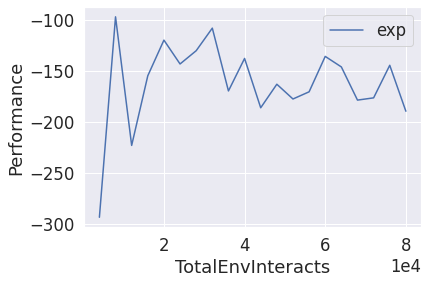

In [ ]:
plt.figure()
data = get_datasets(ddpg_output_dir)
plot_data(data, xaxis='TotalEnvInteracts', value='Performance', smooth=1)

We can also run the trained agents as below (set render=True to visualize - note that additional settings may be required to view on Colab or on a remote server)

Note: In order for this code to work, the MLPActorCritic model definition (and dependencies) should be in scope.

A solved pendulum controller would typically have EpRet > -150.

In [ ]:
playback_env, get_action = load_policy_and_env(ddpg_output_dir, 'last', True)
run_policy(playback_env, get_action, num_episodes=10, render=False)
playback_env.close()



Loading from /content/drive/MyDrive/Users/青椒/CS523/hw5_stuffs/ddpg/pyt_save/model.pt.


Logging data to /tmp/experiments/1650469895/progress.txt
Episode 0 	 EpRet -1.371 	 EpLen 200
Episode 1 	 EpRet -116.307 	 EpLen 200
Episode 2 	 EpRet -117.677 	 EpLen 200
Episode 3 	 EpRet -125.480 	 EpLen 200
Episode 4 	 EpRet -118.403 	 EpLen 200
Episode 5 	 EpRet -120.313 	 EpLen 200
Episode 6 	 EpRet -261.474 	 EpLen 200
Episode 7 	 EpRet -124.682 	 EpLen 200
Episode 8 	 EpRet -121.751 	 EpLen 200
Episode 9 	 EpRet -126.205 	 EpLen 200
-------------------------------------
|    AverageEpRet |            -123 |
|        StdEpRet |            58.4 |
|        MaxEpRet |           -1.37 |
|        MinEpRet |            -261 |
|           EpLen |             200 |
-------------------------------------


## Q2 Sequence to Sequence Modelling with nn.Transformer and Torch Text (20 points)

You will implement a part of transformer. This question aims to let you to get familiar with the transformer architecture purposed in the paper [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf). This question is modified from the original pytorch tutorial [here](https://pytorch.org/tutorials/beginner/transformer_tutorial.html?highlight=transformer), you can refer it when you fill out the code. The general architecture of trasnsformer is shown in the figure below:

<img src="http://ai.bu.edu/DL523/HW5_files/transformer_architecture.jpg" width="360em">

This question requires you to implement a sequence to sequence model by encoder, which is the left part of the figure. You will use integrated layers in pytorch.

The transformer model has been proved to be superior in quality for many sequence-to-sequence
problems while being more parallelizable. The ``nn.Transformer`` module
relies entirely on an attention mechanism (another module recently
implemented as `nn.MultiheadAttention`) to draw global dependencies
between input and output. The ``nn.Transformer`` module is now highly
modularized such that a single component (like [`nn.TransformerEncoder `](<https://pytorch.org/docs/master/nn.html?highlight=nn%20transformerencoder#torch.nn.TransformerEncoder>)
in this tutorial) can be easily adapted/composed.

In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Q2.1 Define the model 
In this question, we train ``nn.TransformerEncoder`` model on a
language modeling task. The language modeling task is to assign a
probability for the likelihood of a given word (or a sequence of words)
to follow a sequence of words. A sequence of tokens are passed to the embedding
layer first, followed by a positional encoding layer to account for the order
of the word (see the next paragraph for more details). The
``nn.TransformerEncoder`` consists of multiple layers of
``nn.TransformerEncoderLayer`` . Along with the input sequence, a square
attention mask is required because the self-attention layers in
``nn.TransformerEncoder`` are only allowed to attend the earlier positions in
the sequence. For the language modeling task, any tokens on the future
positions should be masked. To have the actual words, the output
of ``nn.TransformerEncoder`` model is sent to the final Linear
layer, which is followed by a log-Softmax function. We will see how to implement the ``PositionalEncoding`` in the later question. 

<img src="http://ai.bu.edu/DL523/HW5_files/encoder.png" width="em">

In the following model, we only train a encoder model, which is the left part of the figure. Then we concatenate a Linear model `self.decoder` to replace the right part of the model.

**TO AVOID ISSUES WITH PACKAGE IMPORTS, IT MIGHT BE WORTH RESTARTING THE NOTEBOOK KERNEL**

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import typing


class TransformerModel(nn.Module):
    def __init__(self,
                 token_nums: int,
                 input_embedding_dim: int,
                 multi_head_nums: int,
                 hidden_nums: int,
                 layer_nums: int,
                 dropout: float = 0.5):
        """This is a transformer encoder model, the input arguments are as follows:

        :param token_nums dimension of tokens
        :param input_embedding_dim dimension of input embeddings
        :param multi_head_nums the number of heads in the Multi-Head Attention model
        :param hidden_nums dimension of the hidden encoding between two layers of TransformerEncoderLayer
        :param layer_nums number of TransformerEncoderLayer layers
        """
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer

        self.model_type = 'Transformer'

        self.embedding_encoder = nn.Embedding(token_nums, input_embedding_dim)
        self.input_embedding_dim = input_embedding_dim

        self.positional_encoder = PositionalEncoding(input_embedding_dim, dropout)
        encoder_layers = TransformerEncoderLayer(input_embedding_dim, multi_head_nums, hidden_nums, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, layer_nums)
        self.linear_decoder = nn.Linear(input_embedding_dim, token_nums)

        self.init_weights()

    def generate_square_subsequent_mask(self, size: int) -> torch.Tensor:
        """
        Generate a square mask for the sequence.
        The masked positions are filled with float('-inf').
        :param size: the size of the mask
        :return: A series of masked vectors.
        """

        # actually returns a matrix of size * size, with -inf in the first row
        # except for the first element, which is 0. Then on the next lines, more
        # and more elements that are not -inf are added,
        # until the last line, when there are no more -inf elements
        #
        # tensor([[0., -inf, -inf, -inf, -inf],
        #         [0.,   0., -inf, -inf, -inf],
        #         [0.,   0.,   0., -inf, -inf],
        #         [0.,   0.,   0.,   0., -inf],
        #         [0.,   0.,   0.,   0.,   0.]])

        mask = torch.triu(torch.ones(size, size) * float('-inf') , diagonal=1)
        return mask

    def init_weights(self):
        init_range = 0.1
        self.embedding_encoder.weight.data.uniform_(-init_range, init_range)
        self.linear_decoder.bias.data.zero_()
        self.linear_decoder.weight.data.uniform_(-init_range, init_range)

    def forward(self,
                src: torch.Tensor,
                src_mask: torch.Tensor) -> torch.Tensor:
        # 1. We will convert tokens into embeddings
        src = self.embedding_encoder(src) * math.sqrt(self.input_embedding_dim)

        # 2. We will add positional encoding
        src = self.positional_encoder(src)

        # 3. We will apply the TransformerEncoder
        output = self.transformer_encoder(src, src_mask)

        # 4. We will apply a linear layer to the output
        output = self.linear_decoder(output)
        
        return output


### Q2.2 Positional Encoding
#### Q2.2.1 Fill the code block
``PositionalEncoding`` module injects some information about the
relative or absolute position of the tokens in the sequence. The
positional encodings have the same dimension as the embeddings so that
the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
different frequencies.


In [ ]:
class PositionalEncoding(nn.Module):
    """
    This class implements the positional encoding as described in "Attention is all you need"

    `PositionalEncoding` module injects some information about the relative or absolute position of the tokens in the
    sequence.

    The positional encodings have the same dimension as the embeddings so that the two can be summed. Here,
    we use sine and cosine functions of different frequencies.
    """

    def __init__(self,
                 embedding_dim: int,
                 dropout: int =0.1,
                 max_length: int = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-math.log(10000.0) / embedding_dim))
        pe = torch.zeros(max_length, 1, embedding_dim)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """YOUR CODE HERE"""
        x = x + self.pe[:x.size(0), :]
        output = self.dropout(x)
        """YOUR CODE ENDS"""
        return output


#### Q2.2.2 Why do we need this positional encoding in the transformer architecture?

Positional encoding provides a solution that helps to account for the order of words in the input sequence. It will introduce a new vector values to the embedding, which contains information about the meaningful distances between word's positions and distances. This can helps the model to recover the position of each words during output stage.

### Q2.3 Running the model

#### Q2.3.1 Run the code to get desired performance.
The training process uses Wikitext-2 dataset from ``torchtext``. The
vocab object is built based on the train dataset and is used to numericalize
tokens into tensors. Starting from sequential data, the ``batchify()``
function arranges the dataset into columns, trimming off any tokens remaining
after the data has been divided into batches of size ``batch_size``.
For instance, with the alphabet as the sequence (total length of 26)
and a batch size of 4, we would divide the alphabet into 4 sequences of
length 6:

$$
\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}
$$

These columns are treated as independent by the model, which means that
the dependence of ``G`` and ``F`` can not be learned, but allows more
efficient batch processing.


**Note**, we're using torchtext v 0.11.0

You *may* need to run the following code block below if running locally if errors are thrown about missing packages or components (though check the rest first before going through this)

In [ ]:
!pip install "torchtext==0.11"
!pip install "spacy>=2.2.4,<=3.2.4"
!python -m spacy download en_core_web_sm

In [ ]:
import torchtext
from torchtext.legacy import data
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader


TEXT = torchtext.legacy.data.Field(tokenize=get_tokenizer("spacy"),
                                   init_token='<sos>',
                                   eos_token='<eos>',
                                   lower=True)

train_txt, val_txt, test_txt = torchtext.legacy.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def batchify(data: Dataset,
             batch_size: int) -> torch.Tensor:
    data = TEXT.numericalize([data.examples[0].text])
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // batch_size
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * batch_size)
    # Evenly divide the data across the bsz batches.
    data = data.view(batch_size, -1).t().contiguous()
    return data.to(device)


batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

The ``get_batch()`` function generates the input and target sequence for
the transformer model. It subdivides the source data into chunks of
length ``bptt``. For the language modeling task, the model needs the
following words as ``Target``. For example, with a ``bptt`` value of 2,
we’d get the following two Variables for ``i`` = 0:

<img src="http://ai.bu.edu/DL523/HW5_files/transformer_input_target1.png" width="em">
<!-- ![](transformer_input_target.png) -->


It should be noted that the chunks are along dimension 0, consistent
with the ``S`` dimension in the Transformer model. The batch dimension
``N`` is along dimension 1.


In [ ]:
# The get_batch() function will use the value bptt to subdivide the data into chunks of length bptt.
# For example, if bptt is 2, we get the following two variables with i = 0.
bptt: int = 35


def get_batch(source: torch.Tensor, i: int) -> typing.Tuple[torch.Tensor, torch.Tensor]:
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i + seq_len]
    target = source[i + 1:i + 1 + seq_len].reshape(-1)
    return data, target


ntokens = len(TEXT.vocab.stoi)  # the size of vocabulary
emsize = 200  # embedding dimension
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0.2  # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time


def train() -> None:
    model.train()  # Turn on the train mode
    total_loss = 0.0
    log_interval = 10
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    num_batches = len(train_data) // bptt

    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    print("in training loop")
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        batch_size = data.size(0)

        if batch_size != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data, src_mask)

        # begin to calculate the loss
        loss = criterion(output.view(-1, ntokens), targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            # because the learning rate is changing,
            # we need to fetch the latest learning rate.
            learningRate = scheduler.get_last_lr()[0]
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {learningRate:02.2f} | ms/batch {elapsed * 1000 / log_interval:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {math.exp(cur_loss):8.2f}')
            total_loss = 0
            start_time = time.time()


def evaluate(model: nn.Module, eval_data: torch.Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            batch_size = data.size(0)
            if batch_size != bptt:
                src_mask = src_mask[:batch_size, :batch_size]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += batch_size * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

Running the code block below. You will get around 220 ppl on training at the end of epoch 1.

In [ ]:
best_val_loss = float("inf")
epochs = 1 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    print("starting")
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    scheduler.step()

starting
in training loop
| epoch   1 |    10/ 3195 batches | lr 5.00 | ms/batch 32.10 | loss 10.90 | ppl 54110.16
| epoch   1 |    20/ 3195 batches | lr 5.00 | ms/batch  7.60 | loss  8.65 | ppl  5702.83
| epoch   1 |    30/ 3195 batches | lr 5.00 | ms/batch  7.43 | loss  8.67 | ppl  5827.13
| epoch   1 |    40/ 3195 batches | lr 5.00 | ms/batch  7.55 | loss  7.98 | ppl  2919.76
| epoch   1 |    50/ 3195 batches | lr 5.00 | ms/batch  8.22 | loss  7.60 | ppl  1990.59
| epoch   1 |    60/ 3195 batches | lr 5.00 | ms/batch  7.45 | loss  7.47 | ppl  1752.93
| epoch   1 |    70/ 3195 batches | lr 5.00 | ms/batch  7.34 | loss  7.21 | ppl  1355.31
| epoch   1 |    80/ 3195 batches | lr 5.00 | ms/batch  7.29 | loss  7.18 | ppl  1315.49
| epoch   1 |    90/ 3195 batches | lr 5.00 | ms/batch  7.21 | loss  6.93 | ppl  1024.09
| epoch   1 |   100/ 3195 batches | lr 5.00 | ms/batch  7.57 | loss  7.04 | ppl  1144.61
| epoch   1 |   110/ 3195 batches | lr 5.00 | ms/batch  7.03 | loss  6.80 | ppl   89

#### 2.3.2 Why do we need to use `torch.nn.utils.clip_grad_norm_` in training?

Set a threshold for gradient clipping, and if the gradient exceeds this threshold when updating the gradient, it will be limited to this range to prevent the gradient from exploding.